<a href="https://colab.research.google.com/github/Ankan1998/Semantic-Segmentation/blob/main/Semantic_Segmentation_deeplabV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Semantic Segmentation with pytorch for beginner**

## **Motivation for these colab**
#### Being a self taught beginner, I faced a lot of issue going into advanced deep learning stuff for not having standard repos which are easy to understand. This is the reason, I decided to write these colab to simplify and understandable semantic segmentation for beginner.

### My blog : datasciencey.blogspot.com


## Created by Ankan Sharma
### email- ankanroni3@gmail.com 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Mon Oct 19 10:53:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import zipfile
import torch
import torchvision
import numpy as np
from PIL import Image
from tqdm import tqdm

### **Kaggle preparation**
##### Aerial dataset of kaggle

In [4]:
#upload kaggle json token
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 2.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.8-cp36-none-any.whl size=73275 sha256=9bee8d0658c5024041915977d1fe5315e8594c3014c0f293fe9e5245df749562
  Stored in directory: /root/.cache/pip/wheels/94/a7/09/68dc83c7c14fdbdf5d3f2b2da5b87e587bfc1e85df69b1130c
Successfully built kaggle
  Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8


In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset -p "/tmp"

100% 3.83G/3.83G [01:11<00:00, 36.6MB/s]
100% 3.83G/3.83G [01:11<00:00, 57.4MB/s]


In [8]:
local_zip='/tmp/semantic-drone-dataset.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall("/content")
zip_ref.close()

### **Checking with one pair of image**

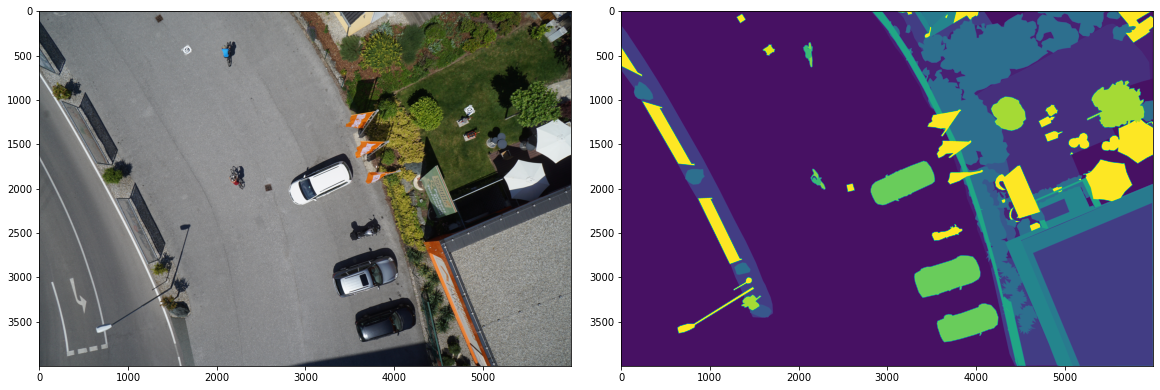

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

original_image = "/content/semantic_drone_dataset/original_images/004.jpg"
label_image_semantic = "/content/semantic_drone_dataset/label_images_semantic/004.png"

fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

axs[0].imshow( Image.open(original_image))

axs[1].imshow(Image.open(label_image_semantic))


In [41]:
import cv2
 
img = cv2.imread('/content/semantic_drone_dataset/original_images/008.jpg', cv2.IMREAD_UNCHANGED)
mask = cv2.imread('/content/semantic_drone_dataset/label_images_semantic/008.png')
dim = (256, 256)
# resize image
resized_mask = cv2.resize(mask, dim)
resized_img = cv2.resize(img, dim)

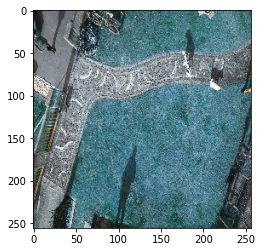

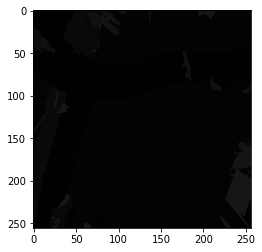

In [42]:
plt.imshow(resized_img)
plt.show()
plt.imshow(resized_mask)
plt.show()

## **Constructing Custom dataset**

In [9]:
from torch.utils.data import Dataset, DataLoader, sampler

In [ ]:
"""
def classes(mask_dir):
  mask_file=os.listdir(mask_dir)
  mask_class=[]
  for i in range(len(mask_file)):
    mask_name=os.path.join(mask_dir,mask_file[i])
    mask = Image.open(mask_name)
    mask_class.append(max(list(np.unique(np.array(mask)))))
    print(mask_class)
  return max(mask_class)

  
NUM_OF_CLASSES=classes("/content/semantic_drone_dataset/label_images_semantic")
"""

'\ndef classes(mask_dir):\n  mask_file=os.listdir(mask_dir)\n  mask_class=[]\n  for i in range(len(mask_file)):\n    mask_name=os.path.join(mask_dir,mask_file[i])\n    mask = Image.open(mask_name)\n    mask_class.append(max(list(np.unique(np.array(mask)))))\n    print(mask_class)\n  return max(mask_class)\n\n  \nNUM_OF_CLASSES=classes("/content/semantic_drone_dataset/label_images_semantic")\n'

In [11]:
# Find number of classes category
NUM_OF_CLASSES=26

In [12]:
# Creating own dataset
class Satellite_Dataset(Dataset):
    def __init__(self, img_dir,mask_dir,transform=None):
      # Getting image directory and annotated mask directory
      self.img_dir=img_dir
      self.mask_dir=mask_dir
      self.img_file_list=sorted(os.listdir(img_dir))
      self.mask_file_list=sorted(os.listdir(mask_dir))
      self.transform = transform
        

    def __len__(self):
      return len(self.img_file_list)

    def __getitem__(self, index):
      img_name=os.path.join(self.img_dir, self.img_file_list[index])
      img = Image.open(img_name)
      mask_name=os.path.join(self.mask_dir, self.mask_file_list[index])
      mask = (Image.open(mask_name)).resize((256,256))
      mask=np.array(mask)
      if self.transform:
        img = self.transform(img)
        #mask = self.transform(mask)
      mask = torch.Tensor(mask).long()
      #mask=torch.squeeze(mask,0)
      # Here we are inserting image tensor and its mask tensor (similiar to labels in classification )  
      return (img,mask)


In [13]:
# normalizing mean and std according to docs
from torchvision import transforms
# change the directory accordingly
img_dir="/content/semantic_drone_dataset/original_images"
mask_dir="/content/semantic_drone_dataset/label_images_semantic"
transform_img = transforms.Compose([
                            transforms.Resize((256,256)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

dataset = Satellite_Dataset(img_dir, mask_dir, transform= transform_img)

In [43]:
len(dataset)

400

In [44]:
# checking for shapes
x, y = dataset[7]
x.shape, y.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


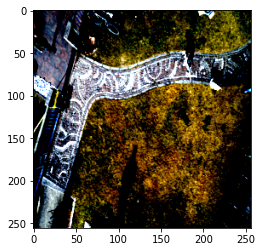

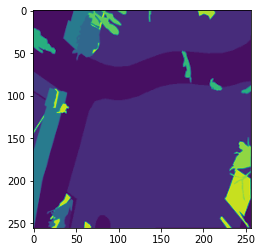

In [45]:
# permuting to change to (256,256,3)
x=x.permute((1,2,0))
plt.imshow(x)
plt.show()
plt.imshow(y)

In [14]:
# Splitting into train and val set
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [350, 50])

In [29]:
# passing into dataloader
train_dl = DataLoader(train_dataset, batch_size=35, shuffle=True,num_workers=10)
valid_dl = DataLoader(val_dataset, batch_size=25, shuffle=True,num_workers=10)

In [46]:
# checking the shapes for batches of images
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([35, 3, 256, 256]), torch.Size([35, 256, 256]))

## **DeepLabV3 model**

In [30]:
import torchvision.models as models

In [31]:
deeplabv3_resnet_50=models.segmentation.deeplabv3_resnet50(pretrained=False,progress=True, num_classes=NUM_OF_CLASSES)

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device="cpu"
deeplabv3_resnet_50=deeplabv3_resnet_50.to(device)

In [48]:
device

'cuda'

In [49]:
xb=xb.to(device)
y=deeplabv3_resnet_50(xb)['out'] # returns ordereddict, so mention['out'] to get the desired output
y.shape

torch.Size([35, 26, 256, 256])

In [33]:
#loss function
loss=torch.nn.CrossEntropyLoss()

#optimizer
# NB: Hyperparameter Tune with callbacks to get better result
optimizer=torch.optim.Adam(deeplabv3_resnet_50.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.000001)

In [34]:
epochs = 50
for e in tqdm(range(epochs)):
    running_loss = 0
    #c=0
    for images, labels in train_dl:
        images,labels=images.to(device),labels.to(device)
        # Training pass
        #print(type(labels))
        optimizer.zero_grad()
        
        output = deeplabv3_resnet_50(images)["out"]
        labels=labels.long()
        lossi = loss(output, labels)
        lossi.backward()
        optimizer.step()
        #print(f"batch {c}, loss-->{lossi.item()}")
        #c=c+1
        running_loss += lossi.item()
    
    print(f"epoch {e}, loss-->{running_loss}")
    
# Run for more epoch with lr scheduler it would give more accurate results


  2%|▏         | 1/50 [04:15<3:28:40, 255.53s/it]

epoch 0, loss-->21.44515883922577



  4%|▍         | 2/50 [08:29<3:24:00, 255.02s/it]

epoch 1, loss-->13.700713515281677



  6%|▌         | 3/50 [12:42<3:19:18, 254.43s/it]

epoch 2, loss-->12.104827165603638



  8%|▊         | 4/50 [16:54<3:14:28, 253.67s/it]

epoch 3, loss-->10.62318605184555



 10%|█         | 5/50 [21:07<3:10:08, 253.52s/it]

epoch 4, loss-->9.204787969589233



 12%|█▏        | 6/50 [25:21<3:06:00, 253.64s/it]

epoch 5, loss-->8.543447375297546



 14%|█▍        | 7/50 [29:33<3:01:20, 253.04s/it]

epoch 6, loss-->7.996118009090424



 16%|█▌        | 8/50 [33:46<2:57:13, 253.18s/it]

epoch 7, loss-->7.626651644706726



 18%|█▊        | 9/50 [38:00<2:53:09, 253.41s/it]

epoch 8, loss-->7.243409633636475



 20%|██        | 10/50 [42:12<2:48:39, 253.00s/it]

epoch 9, loss-->7.023658037185669



 22%|██▏       | 11/50 [46:24<2:44:09, 252.55s/it]

epoch 10, loss-->7.496917366981506



 24%|██▍       | 12/50 [50:35<2:39:49, 252.36s/it]

epoch 11, loss-->7.057035684585571



 26%|██▌       | 13/50 [54:49<2:35:54, 252.82s/it]

epoch 12, loss-->6.621461868286133



 28%|██▊       | 14/50 [59:05<2:32:10, 253.62s/it]

epoch 13, loss-->6.521442711353302



 30%|███       | 15/50 [1:03:24<2:28:58, 255.38s/it]

epoch 14, loss-->6.351601183414459



 32%|███▏      | 16/50 [1:07:54<2:27:07, 259.63s/it]

epoch 15, loss-->6.023943662643433



 34%|███▍      | 17/50 [1:12:12<2:22:31, 259.12s/it]

epoch 16, loss-->5.730163007974625



 36%|███▌      | 18/50 [1:16:25<2:17:18, 257.45s/it]

epoch 17, loss-->5.463991433382034



 38%|███▊      | 19/50 [1:20:39<2:12:27, 256.38s/it]

epoch 18, loss-->5.257108151912689



 40%|████      | 20/50 [1:24:52<2:07:40, 255.35s/it]

epoch 19, loss-->5.081224292516708



 42%|████▏     | 21/50 [1:29:04<2:02:53, 254.27s/it]

epoch 20, loss-->4.980163425207138



 44%|████▍     | 22/50 [1:33:18<1:58:40, 254.29s/it]

epoch 21, loss-->4.835632294416428



 46%|████▌     | 23/50 [1:37:32<1:54:22, 254.16s/it]

epoch 22, loss-->4.758533865213394



 48%|████▊     | 24/50 [1:41:44<1:49:51, 253.53s/it]

epoch 23, loss-->4.591113865375519



 50%|█████     | 25/50 [1:45:56<1:45:28, 253.14s/it]

epoch 24, loss-->4.530612140893936



 52%|█████▏    | 26/50 [1:50:10<1:41:16, 253.20s/it]

epoch 25, loss-->4.441213041543961



 54%|█████▍    | 27/50 [1:54:21<1:36:52, 252.71s/it]

epoch 26, loss-->4.369779139757156



 56%|█████▌    | 28/50 [1:58:35<1:32:43, 252.87s/it]

epoch 27, loss-->4.3145304918289185



 58%|█████▊    | 29/50 [2:02:47<1:28:29, 252.82s/it]

epoch 28, loss-->4.216446042060852



 60%|██████    | 30/50 [2:07:01<1:24:24, 253.23s/it]

epoch 29, loss-->4.1662033796310425



 62%|██████▏   | 31/50 [2:11:19<1:20:36, 254.54s/it]

epoch 30, loss-->4.177710980176926



 64%|██████▍   | 32/50 [2:15:37<1:16:41, 255.62s/it]

epoch 31, loss-->4.152149707078934



 66%|██████▌   | 33/50 [2:19:55<1:12:38, 256.36s/it]

epoch 32, loss-->4.126224666833878



 68%|██████▊   | 34/50 [2:24:14<1:08:34, 257.13s/it]

epoch 33, loss-->4.095348805189133



 70%|███████   | 35/50 [2:28:33<1:04:22, 257.51s/it]

epoch 34, loss-->4.0340296626091



 72%|███████▏  | 36/50 [2:32:51<1:00:10, 257.89s/it]

epoch 35, loss-->3.9974112510681152



 74%|███████▍  | 37/50 [2:37:10<55:55, 258.12s/it]  

epoch 36, loss-->3.9973832070827484



 76%|███████▌  | 38/50 [2:41:28<51:36, 258.00s/it]

epoch 37, loss-->3.967004656791687



 78%|███████▊  | 39/50 [2:45:44<47:12, 257.49s/it]

epoch 38, loss-->3.935700476169586



 80%|████████  | 40/50 [2:49:59<42:46, 256.68s/it]

epoch 39, loss-->3.8943734765052795



 82%|████████▏ | 41/50 [2:54:12<38:20, 255.66s/it]

epoch 40, loss-->3.860340118408203



 84%|████████▍ | 42/50 [2:58:24<33:56, 254.61s/it]

epoch 41, loss-->3.838234454393387



 86%|████████▌ | 43/50 [3:02:38<29:40, 254.32s/it]

epoch 42, loss-->3.799728810787201



 88%|████████▊ | 44/50 [3:06:51<25:23, 253.87s/it]

epoch 43, loss-->3.7739776968955994



 90%|█████████ | 45/50 [3:11:02<21:05, 253.12s/it]

epoch 44, loss-->3.7485926151275635



 92%|█████████▏| 46/50 [3:15:14<16:50, 252.66s/it]

epoch 45, loss-->3.735185384750366



 94%|█████████▍| 47/50 [3:19:26<12:37, 252.56s/it]

epoch 46, loss-->3.712190091609955



 96%|█████████▌| 48/50 [3:23:38<08:24, 252.27s/it]

epoch 47, loss-->3.6740357279777527



 98%|█████████▊| 49/50 [3:27:49<04:11, 251.99s/it]

epoch 48, loss-->3.631158947944641



100%|██████████| 50/50 [3:32:00<00:00, 254.42s/it]

epoch 49, loss-->3.634865701198578


In [35]:
torch.save(deeplabv3_resnet_50.state_dict(), "/content/drive/My Drive/Deep Learning/Image Segmentation/Semantic Segmentation/deeplab_checkpoint_v2.pth")

In [36]:
model_path="/content/drive/My Drive/Deep Learning/Image Segmentation/Semantic Segmentation/deeplab_checkpoint_v2.pth"
model_ = models.segmentation.deeplabv3_resnet50(num_classes=NUM_OF_CLASSES).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [37]:
# trying out for 1 batch of mage
X, Y = next(iter(valid_dl))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)['out']
print(Y_pred.shape)
# getting argmax of last layer for axis with 26 dimension
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([25, 26, 256, 256])
torch.Size([25, 256, 256])


In [38]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

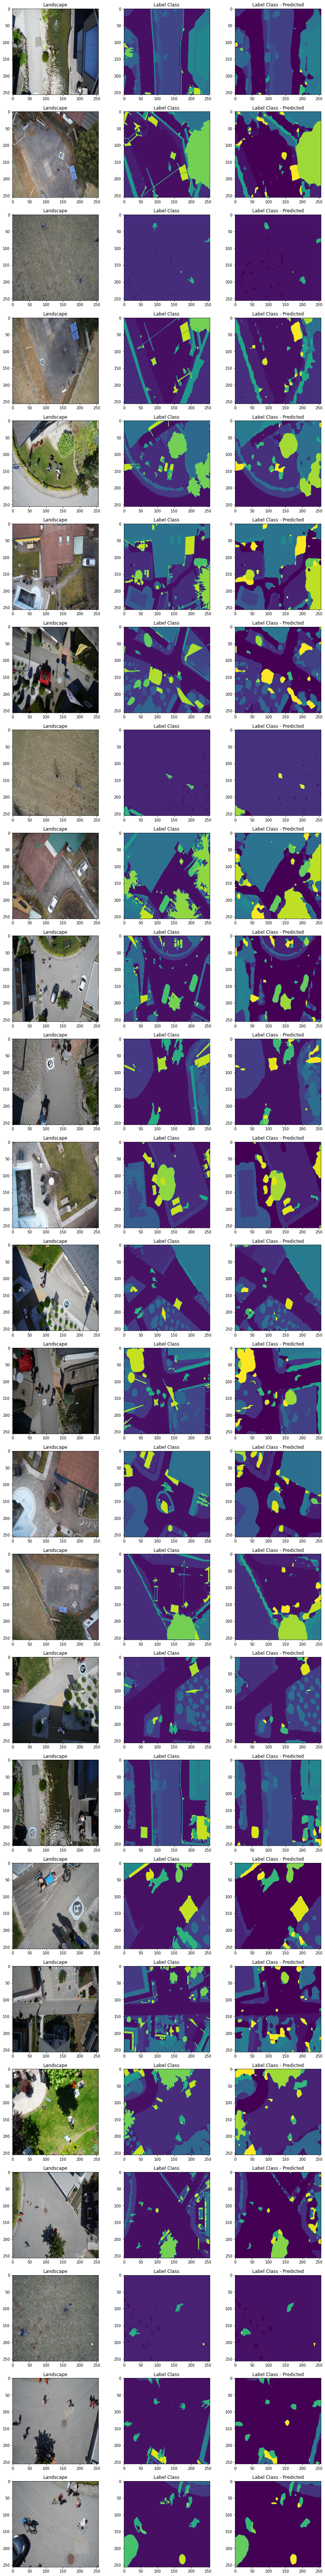

In [39]:
fig, axes = plt.subplots(25, 3, figsize=(3*5, 25*5))

for i in range(25):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")